## Goal: Indexes for the flash drougth project

In this notebook, I am working to a script the calculates indexes we need for the flash drougth project. These will be timeseries for the area-integrated Rhine basin. 


### The indexes we need are: 

- SPI standardized precipitation index. Variable: precipitation
- SPEI standardized precipitation/evapotranspiration index. Variable: precipitation - potential evapotranspiration
- ESI/SESR evaporative stress index/standardized evaporative stress ratio. Variable: evapotranspiration/potential evapotranspiration
- SMI soil moisture index. Variable: soil moisture

### Input variables for the script

- Variable to standardize 
- Time scale (For now we test all variables for 7, 14, 21, 28 day time scales)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# import functions (and packages) from R
r_time_series = robjects.r('ts')

In [12]:
def read_in_ERA5(var, diri, basin):
    ds = xr.open_mfdataset(f'{diri}/{var}_{basin}_????.nc')
    da = ds[var]
    return da

In [5]:
def make_index_timeseries(var, diri,basin):
    if var == 'pr' or var == 'mrsos':
        da = read_in_ERA5(var, diri, basin)
    elif var == 'wb':
        da_pr = read_in_ERA5('pr', diri, basin)
        da_pet = read_in_ERA5('pet', diri, basin)
        da = da_pr - da_pet
    elif var == 'es':
        da_et = read_in_ERA5('et', diri, basin)
        da_pet = read_in_ERA5('pet', diri, basin)
        da = da_et / da_pet        
    return da

In [6]:
def calc_standardized_index_daily(da, scale):
    SPEI_package = importr('SPEI')
    r_spei_function = robjects.r['spei']

    # convert to R timeseries
    r_da = r_time_series(robjects.FloatVector(da.values), start = robjects.IntVector([da.time.dt.year[0].values, da.time.dt.month[0].values]), frequency = 365)
    r_standardized_index = r_spei_function(r_da, scale=scale, na_rm=True, distribution='log-Logistic',verbose=False)


    # put standardized index in DataArray
    da_standardized_index = da.copy(deep=True)
    da_standardized_index.values = xr.DataArray(pandas2ri.ri2py_vector(r_standardized_index.rx2('fitted')))
    
    return da_standardized_index

In [7]:
def calc_index_to_netcdf(var, diri, diro, basin, scale):

    da = make_index_timeseries(var, diri,basin)
    da_standardized_index = calc_standardized_index_daily(da, scale)

    # define data with variable attributes as Xarray dataset

    if var == 'pr':
        indexname = 'SPI'
    elif var == 'mrsos':
        indexname = 'SMI'
    elif var == 'wb':
        indexname = 'SPEI'
    elif var == 'es':
        indexname = 'ESI'


    var_attr = {'units': '-', 
                        'standard_name': f'{indexname}_{scale}d',
                        'long_name': f'{indexname} standardized index of {var} (scale: {scale}d)',
                        }

    coords={'time': (['time'], da_standardized_index.time.data, da_standardized_index.time.attrs)}
              
    ds_new = xr.Dataset(
    data_vars=dict(
        index=(['time'],  
                      da_standardized_index.data, 
                       var_attr,
    )),
    coords=coords
    )

    ds_new.time.encoding = {'zlib': False,
                        'shuffle': False,
                        'complevel': 0,
                        'fletcher32': False,
                        'contiguous': False,
                        'dtype': np.dtype('float64'),
                        'units': 'days since 1850-01-01 00:00:00',
                        'calendar': 'proleptic_gregorian'
                        }

    ds_new.index.encoding = {'_FillValue': np.nan,
                'missing_value':np.nan,
                'dtype': np.dtype('float64'),
                'zlib': False
            }

    ds_new.to_netcdf(f'{diro}/{indexname}_test.nc')


In [73]:
def main():
    basin = 'Rhine'
    diri='/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
    diro = '/scratch/nklm/Px_flashdroughts/indices_ERA5'
    for var in ['pr','mrsos','wb','es']:
        for scale in [7,14,21,28]:
            calc_index_to_netcdf(var, diri, diro, basin, scale)


In [75]:
if __name__ == '__main__':
    sys.exit(main())

7
14
21
28


In [13]:
diri = '/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
basin = 'Rhine'

da_et = read_in_ERA5('et', diri, basin)
da_pet = read_in_ERA5('pet', diri, basin)

In [69]:
infile = '/scratch/nklm/Px_flashdroughts/indices_ERA5/ESI-7_Rhine.nc'
ds = xr.open_dataset(infile)

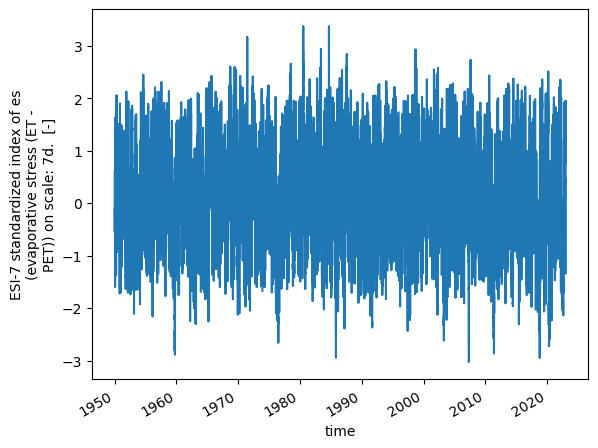

In [70]:
ds['ESI-7'].plot()

In [71]:
np.isinf(ds['ESI-7']).sum()

<xarray.DataArray 'ESI-7' ()>
array(0)

In [38]:
# da_pet = np.where(da_pet.values<0, 0)
da_pet[da_pet < 0] = 0
da_et[da_et < 0 ] = 0
da = da_et / da_pet

da[da > 5] = 5

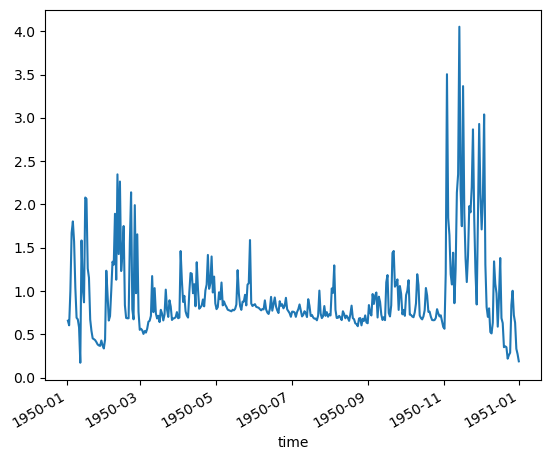

In [40]:
da[0:365].plot()

In [41]:
scale = 14
da_standardized_index = calc_standardized_index_daily(da, scale)

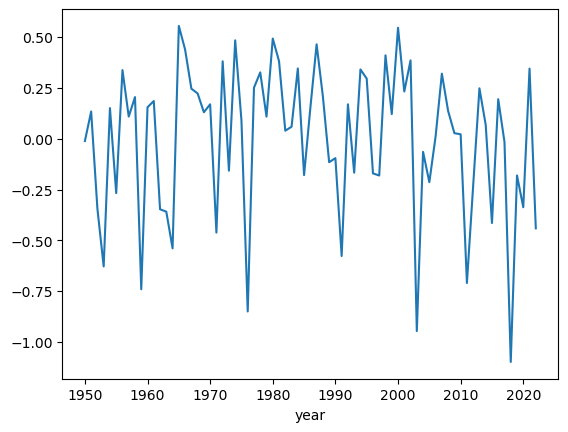

In [64]:
da_standardized_index.groupby('time.year').mean().plot()

In [63]:
da_standardized_index.time

<xarray.DataArray 'time' (time: 26645)>
array(['1950-01-01T11:00:00.000000000', '1950-01-02T11:00:00.000000000',
       '1950-01-03T11:00:00.000000000', ..., '2022-12-29T11:00:00.000000000',
       '2022-12-30T11:00:00.000000000', '2022-12-31T11:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T11:00:00 ... 2022-12-31T11:00:00
Attributes:
    standard_name:  time
    axis:           T

In [25]:
np.where(abs(da.values)>5)

(array([ 1835,  1840,  2173,  2216,  2896,  4349,  5106,  5821,  6218,
         6925,  6936,  7636,  7986,  9121,  9500,  9511, 10211, 10582,
        10583, 10928, 11306, 11317, 12049, 12374, 12401, 12423, 12735,
        13124, 13158, 13162, 13491, 13505, 14207, 14222, 14581, 14583,
        14615, 14966, 15317, 15644, 15655, 15703, 15705, 16036, 16082,
        16420, 16421, 16446, 16780, 16796, 17499, 17500, 17934, 18230,
        18243, 18619, 18948, 18949, 19006, 19346, 19690, 19691, 19721,
        19722, 20060, 20067, 20094, 20117, 20424, 20507, 20822, 21140,
        21168, 22614, 22630, 22634, 22650, 22990, 22998, 23710, 23711,
        24048, 24057, 24074, 24823, 24841, 25155, 25162, 25174, 25184,
        25197, 25525, 26276, 26277, 26278, 26635, 26636]),)

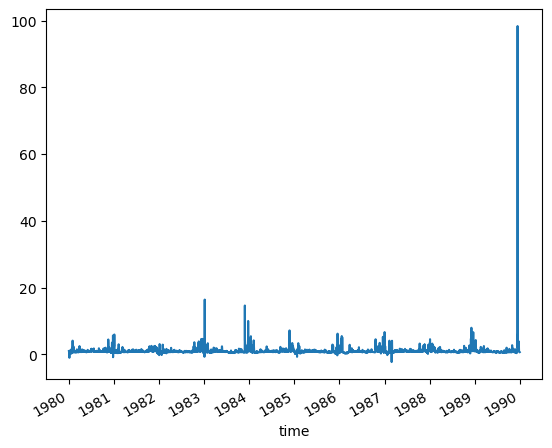

In [32]:
da_copy.plot()

In [27]:
np.where(da_pet.values<0)

(array([    2,  1835,  2519,  2526,  2527,  2558,  2559,  4358,  4386,
         4387,  5106,  6561,  6936,  7699,  8008,  8733, 10562, 10563,
        11306, 11307, 11352, 11709, 12047, 12373, 13122, 13123, 13544,
        13854, 13855, 13856, 14213, 14955, 15315, 15320, 15365, 15700,
        15701, 15702, 15703, 16030, 16031, 16082, 16084, 16776, 16780,
        16796, 16797, 17174, 17865, 17934, 18948, 18949, 19329, 19334,
        19335, 19358, 19371, 19716, 20066, 21898, 22277, 22620, 22629,
        22648, 24112, 24409, 24810, 25942, 26272, 26278, 26634, 26636]),)

In [33]:
da_copy.values = da_standardized_index.values

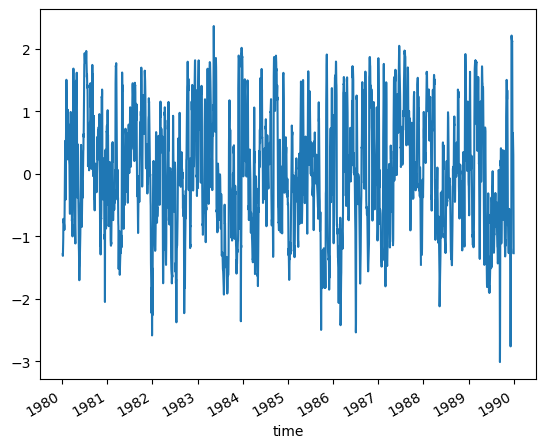

In [34]:
da_copy.plot()

In [60]:
calc_index_to_netcdf('es', diri, basin, scale)

TypeError: Invalid value for attr 'dtype': dtype('float64'). For serialization to netCDF files, its value must be of one of the following types: str, Number, ndarray, number, list, tuple

In [70]:
calc_index_to_netcdf('es', diri, basin, scale)

TypeError: data type 'ndarray' not understood

In [71]:
type(da_standardized_index) # = calc_standardized_index_daily(da, scale)

xarray.core.dataarray.DataArray

In [43]:
da_standardized_index[0:10]

<xarray.DataArray (time: 10)>
array([        nan,         nan,         nan,         nan,         nan,
               nan, -1.28519195, -1.31210687, -1.23941948, -1.12677793])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T11:00:00 ... 1980-01-10T11:00:00

In [13]:
da = make_index_timeseries('es', diri,basin)

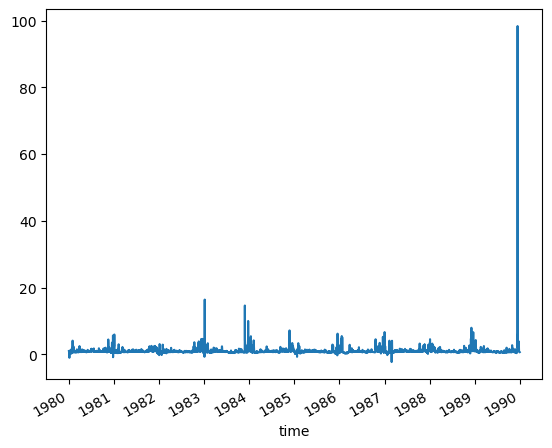

In [22]:
da.plot()